In this notebook we perform chemical identification from experimental images

Load packages and set random seeds

In [1]:
def morgan_fp_gen(smiles, nBits=2048):
    m1 = AllChem.MolFromSmiles(smiles)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=nBits)
    return np.array(fp1)

def load_jmol(path, dimension=[224,224], zoom=1):
    jmol_image = Image.open(path)

    # Determine the aspect ratio by finding the shorter dimension
    width, height = jmol_image.size
    min_dim = min(width, height)

    # Calculate the left, top, right, bottom coordinates for cropping
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2

    # Crop the image to square
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)

    return jmol_image_array

def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, interpolation='bilinear'):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:
        
        im_list.append(Image.open(im_path).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    #normalize = transforms.Normalize(
    #    mean=[0.1321, 0.1487, 0.1689, 0.1983, 0.2229, 0.2591, 0.3430, 0.4580, 0.5787, 0.6887],
    #    std=[0.0853, 0.0853, 0.0883, 0.0942, 0.0969, 0.1066, 0.1419, 0.1840, 0.2144, 0.2215]) #this is for K-1

    
    if normalize:

        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack

def load_exp_3_img(path, dimensions=[224,224], zoom=1):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_index in [1,4,7]:
        
        im_list.append(Image.open(path_list[im_index]).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    normalize = transforms.Normalize(
        mean=[0.1487, 0.2229, 0.4580],
        std=[0.0853, 0.0969, 0.1840])
        

    tensor_stack = normalize(tensor_stack)

    return tensor_stack

def load_jmol_image(cid, dimension=[224,224], zoom=1):
    if USER=='manuel':
        path = f'/home/{USER}/QUAM-AFM/QUAM/JMOL_IMAGES/{cid}/{cid}.png' ##Mustang
    else:
        path = f'/scratch/dataset/quam/JMOL_IMAGES/{cid}/{cid}.png' ##Rocinante
    jmol_image = Image.open(path)
     # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    
    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))
    
    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)
    
    return jmol_image_array

def _extract_cid(path):
    return int(path.split('_')[-3])

In [3]:
def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, interpolation='bilinear'):
    '''
    Obtains stack of experimental images from folder path and preprocesses 
    it so we can directly feed it to our CNN.

    Inputs:
    - path: Path of the folder containing the AFM images of the molecule.
    - dimensions: Desired dimensions for the output images. Default is [224,224].
    - zoom: Zoom level for the images. zoom <1 is zoom out and >1 zoom in. Default is 1.
    - normalize: If True, normalizes the output. Default is True.
    - interpolation: Interpolation method to be used. Options are 'bilinear', 'nearest', and 'bicubic'. 
                     Default is 'bilinear'.

    Output:
    - list of PIL images.
    '''
    interpolation_methods = {
        'bilinear': Image.Resampling.BILINEAR,
        'nearest': Image.Resampling.NEAREST,
        'bicubic': Image.Resampling.BICUBIC
    }

    torch_interpolation_methods = {
        'bilinear': transforms.InterpolationMode.BILINEAR,
        'nearest': transforms.InterpolationMode.NEAREST,
        'bicubic': transforms.InterpolationMode.BICUBIC
    }

    if interpolation not in interpolation_methods:
        raise ValueError(f'Interpolation method not recognized. Please use one of {list(interpolation_methods.keys())}.')

    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:        
        im_list.append(Image.open(im_path).resize(dimensions, resample=interpolation_methods[interpolation]).convert('L'))
        
    # Default parameters
    degrees = 0
    h_shift = 0
    v_shift = 0
    shear = 0

    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=torch_interpolation_methods[interpolation],
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    if normalize:
        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack



def rotate_image(image_array, angle, reshape=True, mode='nearest'):
    """
    Rotate a given numpy array image by the specified angle.

    Parameters:
    - image_array (numpy.ndarray): The input image array.
    - angle (float): The rotation angle in degrees.
    - reshape (bool): If True, the output shape will change. If False, the output shape is the same as the input.
    - mode (str): The mode parameter determines how the input array is extended when the filter overlaps a border.

    Returns:
    - numpy.ndarray: The rotated image array.
    """
    return rotate(image_array, angle, reshape=reshape, mode=mode)

In [4]:
# IMPORTS
# additional packages
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import argparse
import os
import time
import glob
import numpy as np
from scipy.ndimage import rotate
from tqdm import tqdm
import scipy
import seaborn as sns
import rdkit.Chem.AllChem as AllChem
import sys
USER = os.getenv('USER')
sys.path.append('../../.')
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy





print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 10
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)


# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)



/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


PyTorch version: 2.2.1+cu121
Packages loaded
Experiment name: exp_imgs
available devices: 0


/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Load data

In [5]:
# Load data
data_path = '../../data/dataset/285k_train_15k_val_test_1024bits_df.gz'
dataset_df = pd.read_pickle(data_path)

train_df = dataset_df[dataset_df['split'] == 'train']
test_df = dataset_df[dataset_df['split'] == 'test']

trainset = QUAM(args, train_df, mode='train')
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=1,
                                           pin_memory=True)
print('Train set samples:', len(trainset))

testset = QUAM(args, test_df.dropna(), mode='test') #dropna for the experimental molecule
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=1,
                                          pin_memory=True)

print('Test set samples:', len(testset))

Train set samples: 285000
Test set samples: 279905


Load model checkpoint

In [6]:
# FOR CPU
# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = '../../models/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'), map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout2d(p=0.5, inplace=False)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
            (0): Conv2d(32, 16, kernel_siz

## Figure experimental images


/tmp/ipykernel_207728/3336589019.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,
/tmp/ipykernel_207728/3336589019.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,


Is the correct CID in the top k candidates? True
First candidate: 29766, second candidate: 84676
Is the correct CID in the top k candidates? True
First candidate: 88955426, second candidate: 130412167
Is the correct CID in the top k candidates? True
First candidate: 59464606, second candidate: 67191
torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
30
Is the correct CID in the top k candidates? False
23073216 13615479


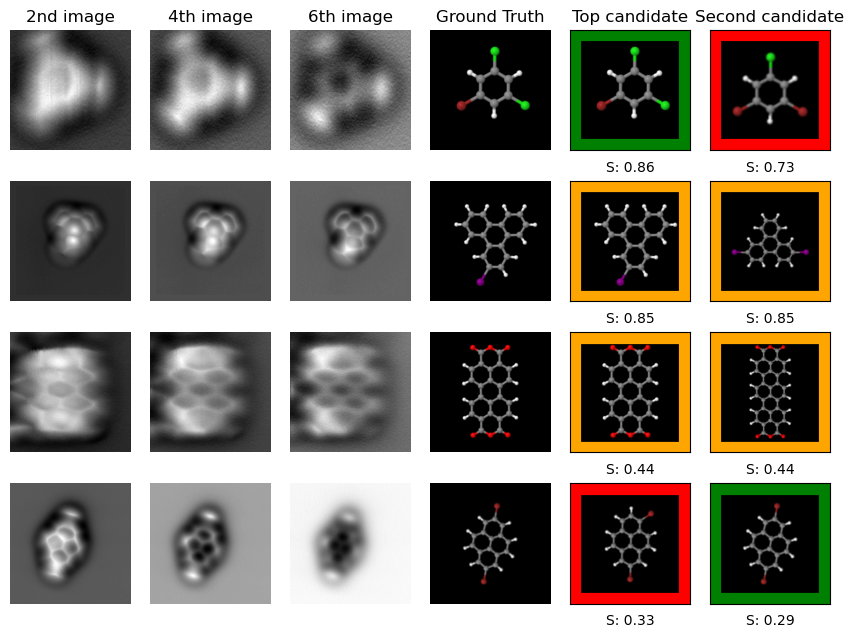

In [9]:
### Add all molecules to experimental_df
path = '/aaa'

experimental_df = test_df
CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
'29766 is included in the quam-afm dataset'
##CID = 29766
##SMILES = 'C1=C(C=C(C=C1Cl)Br)Cl'
##morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
##split='test'
##corrugation = np.nan
##
##
##
##experimental_df = experimental_df.append({'path':path,
##                           'CID':CID, 
##                           'SMILES':SMILES,
##                           'morgan_fp':morgan_fp,
##                           'split':split,
##                           'corrugation':corrugation
##                            }, ignore_index=True)

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)


index_1 = experimental_df[experimental_df['CID'] == 130412167].index[0]
index_2 = experimental_df[experimental_df['CID'] == 88955426].index[0]
#experimental_df[experimental_df['CID'] == 130412167].set_index(index_2)
#experimental_df[experimental_df['CID'] == 88955426].index(index_1)



n_results = 4
fig, ax = plt.subplots(n_results, 6, figsize=(8.5, n_results*1.6))  # Adjust figsize according to your needs

path_list = ['../../data/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene',
             f'../../data/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426',
             f'../../data/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA',
             ]
zoom_list = [1.4, 0.9 , 1]
jmol_zoom_list = [1.3, 1,  1]

CID_list = [29766, 88955426, 67191]
second_cid_list = [84676, 130412167, 59464606]
jmol_paths = ['../../data/EXPERIMENTAL_IMAGES/jmol_images/1-bromo-3,5-dichlorobenzene.jpg',
    '../../data/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg',
    '../../data/EXPERIMENTAL_IMAGES/jmol_images/PTCDA.jpg']

titles = ['2nd image', '4th image', '6th image', 'Ground Truth', 'Top candidate', 'Second candidate']
for i, path in enumerate(path_list):
    gt_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])
    pred_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])

    exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom_list[i], interpolation='bilinear')
    with torch.no_grad():
        batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
        predictions = model(batched_tensor)
        fp_pred = (torch.sigmoid(predictions) > 0.5)

    exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
    output_df = fp_screening_function(exp_fp, experimental_df, top_k = 20)
    tanimoto = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    print('Is the correct CID in the top k candidates?',  CID_list[i] in list(output_df['CID']))
    print(f"First candidate: {output_df.iloc[0]['CID']}, second candidate: {output_df.iloc[1]['CID']}")
   ## print('----------------------')
   ## print(output_df.iloc[0:5])
   ## print('======================')

    cid_second = second_cid_list[i]
    if i == 0:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.5)
    
    elif i == 2:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=1)
        pred_second_jmol = rotate_image(pred_second_jmol, angle=90)
    else:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.9)
    
    ax[i,0].imshow(exp_img[1], cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(exp_img[3], cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(exp_img[5], cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(pred_jmol)
    ax[i,5].imshow(pred_second_jmol)


    
    color = 'green'
    green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    color = 'red'
    red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    color = 'orange'
    yellow_rect1 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    yellow_rect2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    

    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    
    if ((i == 1)|(i ==2)):
        
        ax[i,4].add_patch(yellow_rect1)
        ax[i,5].add_patch(yellow_rect2)
    if i==0:
        ax[i,4].add_patch(green_rect)
        ax[i,5].add_patch(red_rect)
    
    # Setting titles for each column
    if i == 0:
        for j in range(6):
            ax[i,j].set_title(titles[j])

####################################### 

"""Last experimental molecule, since it is a mistake we compute it separately"""


path = f'../../data/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further' 
sample_df = test_df
experimental_df = sample_df


exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.0, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

fp_pred = (torch.sigmoid(predictions) > 0.5)
exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))




# Final figure:
n_results=1



    
true_CID = 13615479

img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

gt_jmol = load_jmol_image(true_CID, dimension=[224,224], zoom=0.7)

pred_CID, second_CID = output_df.iloc[0:2]['CID']
tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
print(pred_CID, second_CID)

pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=0.7)
second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=0.7)

# rotation 
rot_gt_jmol = rotate_image(gt_jmol, angle=80)
pred_jmol = rotate_image(pred_jmol, angle=80)
second_jmol = rotate_image(second_jmol, angle=80)


ax[3,0].imshow(img_1, cmap='gray')
ax[3,0].axis('off')
ax[3,1].imshow(img_3, cmap='gray')
ax[3,1].axis('off')
ax[3,2].imshow(img_5, cmap='gray')
ax[3,2].axis('off')
ax[3,3].imshow(rot_gt_jmol)
ax[3,3].axis('off')
ax[3,4].imshow(pred_jmol)
ax[3,5].imshow(second_jmol)



color = 'green'
green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

color = 'red'
red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

ax[3,4].add_patch(red_rect)
ax[3,4].set_xticks([])
ax[3,4].set_yticks([])
ax[3,4].set_xlabel(f'S: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs

ax[3,5].add_patch(green_rect)
ax[3,5].set_xticks([])
ax[3,5].set_yticks([])
ax[3,5].set_xlabel(f'S: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs



#######################################

plt.tight_layout()
#plt.savefig('experimental_identification_4_molecules_second_candidates_v4.pdf', dpi=500, format='pdf', quality=120, optimize=True)

plt.show()


